# Benchmark Analysis - H8

In [49]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [50]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [51]:
matplotlib.style.use('seaborn-v0_8')  

In [52]:
device_name = 'hydrac'
core_list = [1,2,4,8,16,32]

In [53]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [54]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'brown'


In [55]:
plot_save_dir = './plots/h8'

## Utils 

In [56]:
def get_path(*entries):
    return os.path.join(*entries)

In [57]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [58]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [59]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [60]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [61]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [62]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [63]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [64]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [65]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str,base_of:Optional[str]=None) -> pd.DataFrame:
    
    if base_of is None:
        ## seq base
        seq_base = get_seq_base(bench_name)
    else:
        seq_base = get_seq_base(base_of)

    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H8

> Parallel STL does not inherently provide support for index-based iterations, thereby requiring the developer to devise
> a custom sequence for indices. The manner in which the index values are generated by the developer can significantly
> impact the application's performance and scalability.

## `b9_1_transform_baseline`

In [66]:
benchmark_name = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_1_transform_baseline`

Check how the runtime without constraining the threads develops with increasing input size

In [67]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_1_transform_baseline_time_merged = pd.merge(*data, on='n')

b9_1_transform_baseline_time_merged

,GCC(TBB),n,NVC(OMP)
0,2339.44,4,4644.45
1,4779.11,8,4708.14
2,8666.92,16,5797.35
3,12970.40,32,5999.51
4,17045.20,64,5923.43
5,21671.60,128,5855.37
6,24327.70,256,5864.35
7,26933.60,512,5651.70
8,30109.80,1024,5796.51
9,34148.60,2048,5936.00


### Strong Scaling - `b9_1_transform_baseline`
 
2^26 fixed input size with threads 1-64

In [68]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_1_transform_baseline_strong_scaling_merged = pd.merge(*data, on='threads')

b9_1_transform_baseline_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.992617,0.668637
1,2,1.966953,1.307721
2,4,3.300078,2.609304
3,8,4.304251,4.516994
4,16,5.404727,7.748047
5,32,5.670238,8.246198


In [69]:
## efficiency graph

b9_1_transform_baseline_efficiency = b9_1_transform_baseline_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_1_transform_baseline_efficiency[f'{compiler_name}'] = b9_1_transform_baseline_efficiency[f'{compiler_name}'] / b9_1_transform_baseline_efficiency['threads']



b9_1_transform_baseline_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.992617,0.668637
1,2,0.983476,0.653860
2,4,0.825020,0.652326
3,8,0.538031,0.564624
4,16,0.337795,0.484253
5,32,0.177195,0.257694


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/678994611.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


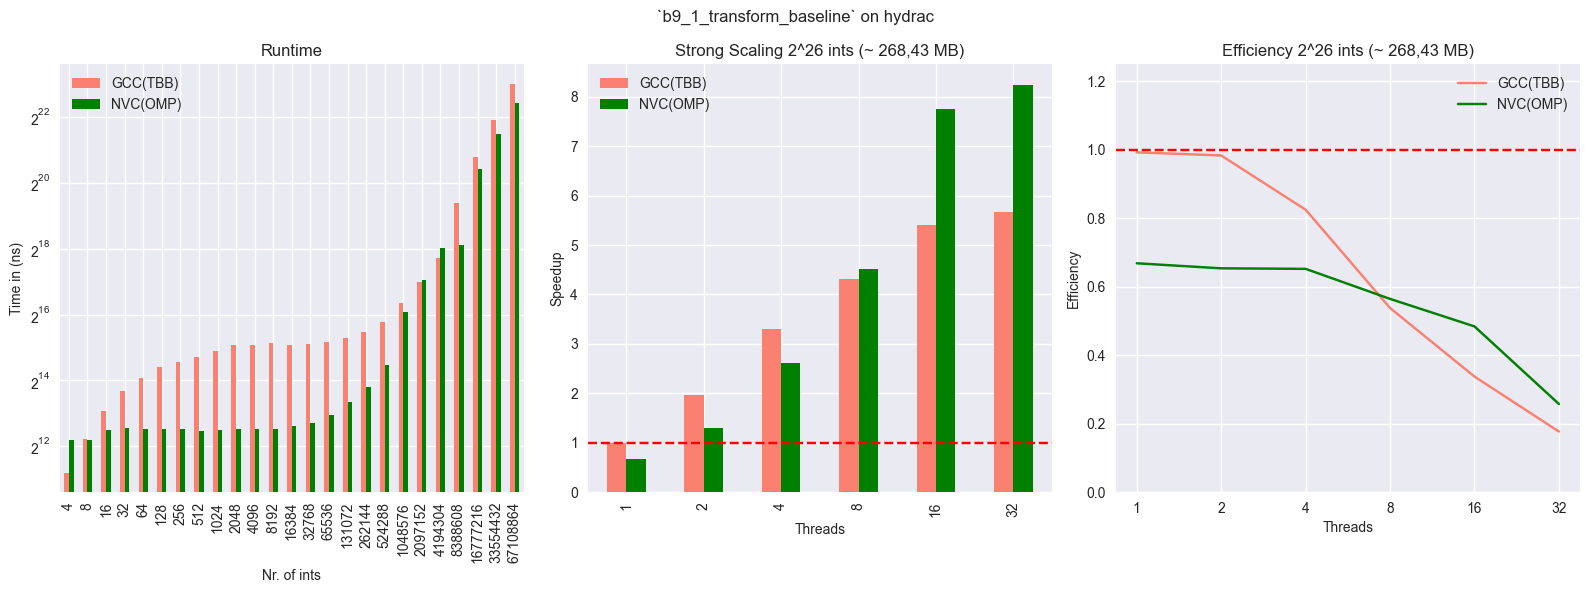

In [70]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_1_transform_baseline_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_1_transform_baseline_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_1_transform_baseline_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_1_transform_baseline` on {device_name}")

fig.tight_layout()

plot(f"`b9_1_transform_baseline` {device_name}")

## `b9_2_transform_old_iota`

In [71]:
benchmark_name = "b9_2_transform_old_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_2_transform_old_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [72]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_2_transform_old_iota_time_merged = pd.merge(*data, on='n')

b9_2_transform_old_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,2.418960e+03,4,4.890430e+03
1,4.945000e+03,8,5.025070e+03
2,9.163570e+03,16,6.124030e+03
3,1.363700e+04,32,6.956160e+03
4,1.739310e+04,64,6.659200e+03
5,2.157010e+04,128,6.447960e+03
6,2.631570e+04,256,7.377830e+03
7,3.007250e+04,512,8.139590e+03
8,3.404590e+04,1024,9.314430e+03
9,3.943920e+04,2048,1.125440e+04


### Strong Scaling - `b9_2_transform_old_iota`
 
2^26 fixed input size with threads 1-64

In [73]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_2_transform_old_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_2_transform_old_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.001538,0.877293
1,2,1.159584,1.055152
2,4,1.284165,1.141817
3,8,1.333759,1.234827
4,16,1.355079,1.251726
5,32,1.324102,1.243207


In [74]:
## efficiency graph

b9_2_transform_old_iota_efficiency = b9_2_transform_old_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_2_transform_old_iota_efficiency[f'{compiler_name}'] = b9_2_transform_old_iota_efficiency[f'{compiler_name}'] / b9_2_transform_old_iota_efficiency['threads']



b9_2_transform_old_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.001538,0.877293
1,2,0.579792,0.527576
2,4,0.321041,0.285454
3,8,0.166720,0.154353
4,16,0.084692,0.078233
5,32,0.041378,0.038850


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/1659612440.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


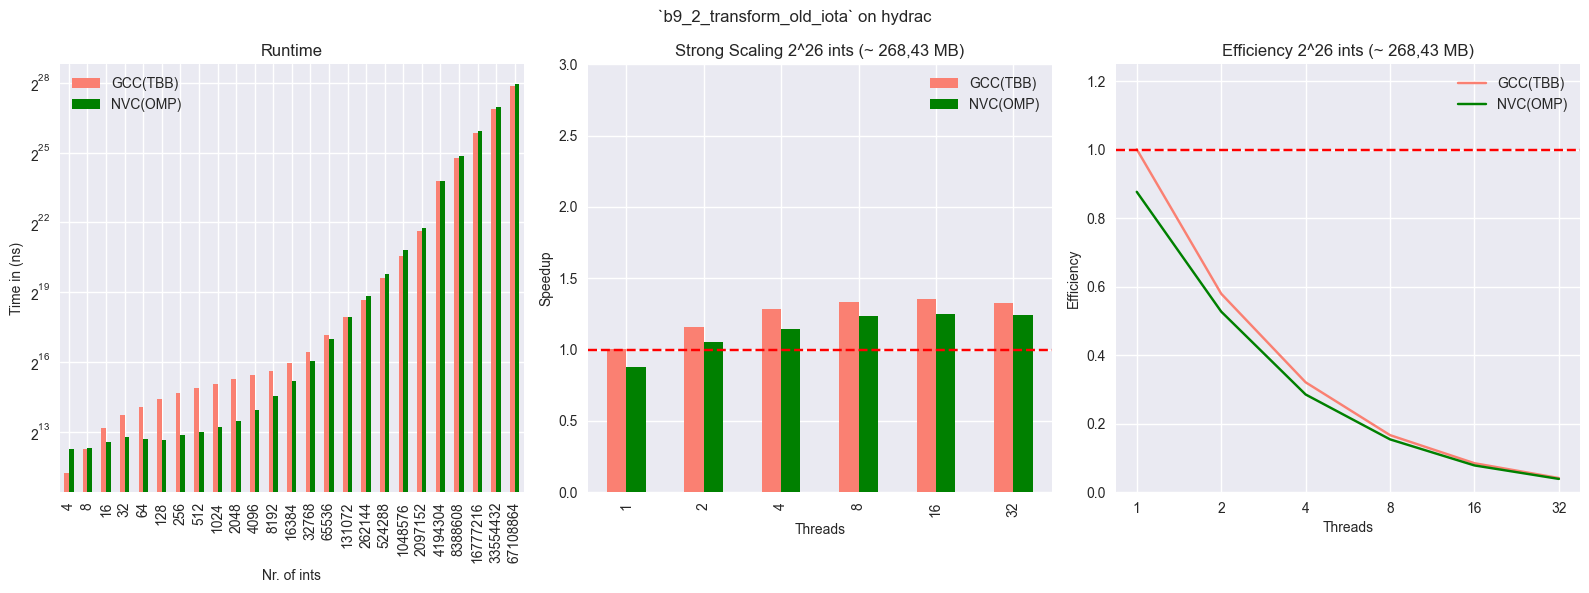

In [75]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_2_transform_old_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_2_transform_old_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_2_transform_old_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_2_transform_old_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_2_transform_old_iota` {device_name}")

## `b9_3_transform_views_iota`

In [76]:
benchmark_name = "b9_3_transform_views_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_3_transform_views_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [77]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_3_transform_views_iota_time_merged = pd.merge(*data, on='n')

b9_3_transform_views_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.103340e+01,4,4933.28
1,3.204000e+01,8,5138.84
2,3.248430e+01,16,5588.93
3,3.392320e+01,32,5960.96
4,3.665380e+01,64,5648.48
5,4.435810e+01,128,5614.82
6,5.713590e+01,256,5587.55
7,8.805010e+01,512,5849.08
8,1.602640e+02,1024,5753.85
9,2.825890e+02,2048,6005.37


### Strong Scaling - `b9_3_transform_views_iota`
 
2^26 fixed input size with threads 1-64

In [78]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_3_transform_views_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_3_transform_views_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.016188,0.418870
1,2,1.010803,0.836781
2,4,1.041667,1.674257
3,8,0.965874,3.208120
4,16,0.960718,5.656908
5,32,0.889237,8.701407


In [79]:
## efficiency graph

b9_3_transform_views_iota_efficiency = b9_3_transform_views_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_3_transform_views_iota_efficiency[f'{compiler_name}'] = b9_3_transform_views_iota_efficiency[f'{compiler_name}'] / b9_3_transform_views_iota_efficiency['threads']



b9_3_transform_views_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.016188,0.418870
1,2,0.505402,0.418391
2,4,0.260417,0.418564
3,8,0.120734,0.401015
4,16,0.060045,0.353557
5,32,0.027789,0.271919


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/1164897114.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


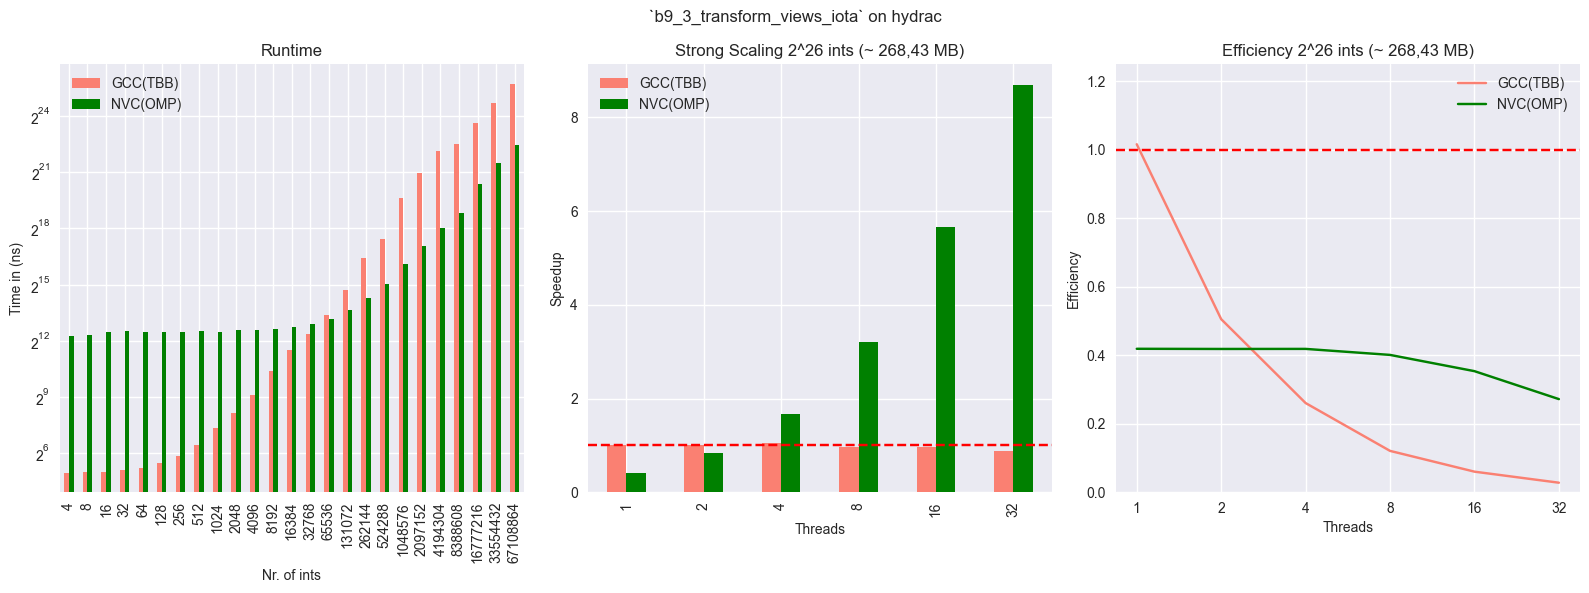

In [80]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_3_transform_views_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_3_transform_views_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_3_transform_views_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_3_transform_views_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_3_transform_views_iota` {device_name}")

## `b9_5_transform_custom_iterator`

In [81]:
benchmark_name = "b9_5_transform_custom_iterator"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_5_transform_custom_iterator`

Check how the runtime without constraining the threads develops with increasing input size

In [82]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_5_transform_custom_iterator_time_merged = pd.merge(*data, on='n')

b9_5_transform_custom_iterator_time_merged

,GCC(TBB),n,NVC(OMP)
0,2231.06,4,4883.88
1,4632.55,8,5164.41
2,9103.43,16,5506.50
3,13260.50,32,6102.52
4,17481.00,64,5669.80
5,22270.20,128,5526.75
6,25479.30,256,5682.97
7,28090.30,512,5751.75
8,31389.30,1024,5664.06
9,35032.30,2048,5511.76


### Strong Scaling - `b9_5_transform_custom_iterator`
 
2^26 fixed input size with threads 1-64

In [83]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_5_transform_custom_iterator_strong_scaling_merged = pd.merge(*data, on='threads')

b9_5_transform_custom_iterator_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.997563,0.468723
1,2,1.961242,0.936864
2,4,3.220678,1.872747
3,8,4.263973,3.453474
4,16,5.341462,5.426948
5,32,5.372186,8.202644


In [84]:
## efficiency graph

b9_5_transform_custom_iterator_efficiency = b9_5_transform_custom_iterator_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] = b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] / b9_5_transform_custom_iterator_efficiency['threads']



b9_5_transform_custom_iterator_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.997563,0.468723
1,2,0.980621,0.468432
2,4,0.805170,0.468187
3,8,0.532997,0.431684
4,16,0.333841,0.339184
5,32,0.167881,0.256333


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/2319354240.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


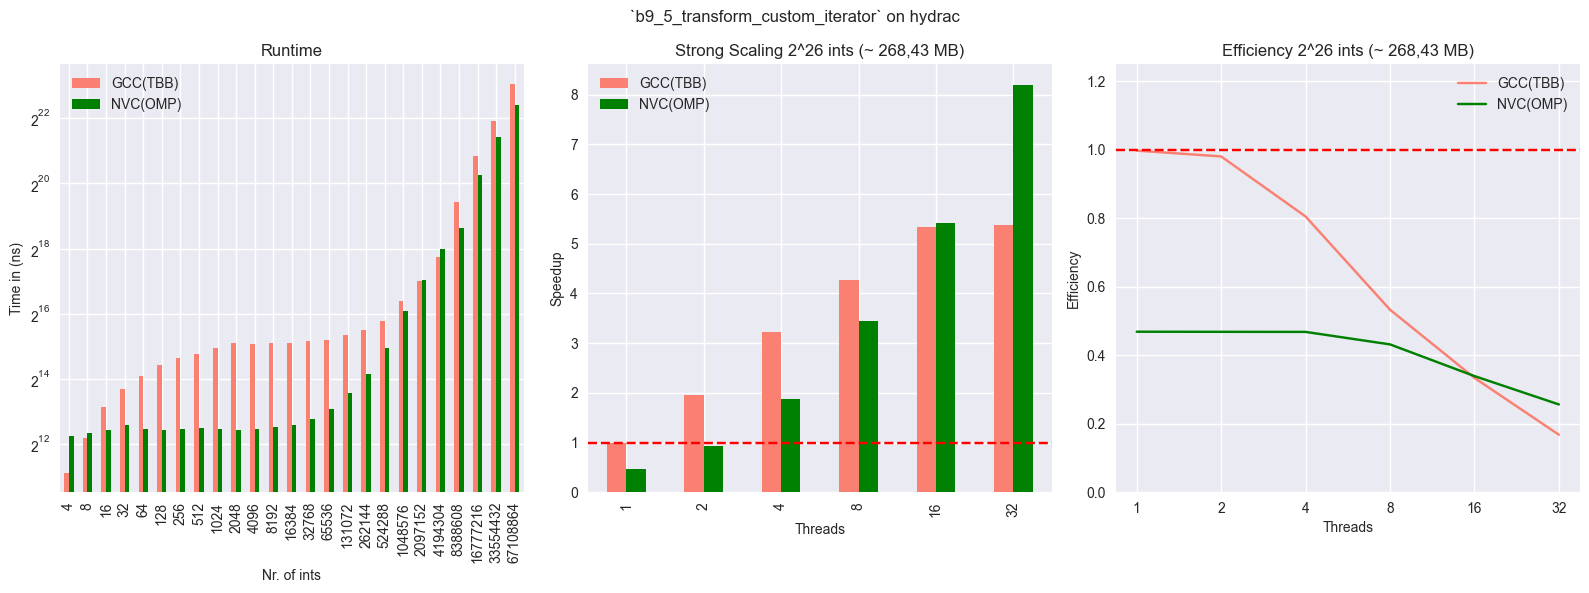

In [85]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_5_transform_custom_iterator_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_5_transform_custom_iterator_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_5_transform_custom_iterator_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_5_transform_custom_iterator` on {device_name}")

fig.tight_layout()

plot(f"`b9_5_transform_custom_iterator` {device_name}")

## `b9_6_transform_boost`

In [86]:
benchmark_name = "b9_6_transform_boost"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_6_transform_boost`

Check how the runtime without constraining the threads develops with increasing input size

In [87]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_6_transform_boost_time_merged = pd.merge(*data, on='n')

b9_6_transform_boost_time_merged

,GCC(TBB),n,NVC(OMP)
0,2361.98,4,5103.36
1,4963.69,8,5109.48
2,9046.84,16,5459.87
3,13625.70,32,5813.86
4,18450.00,64,5451.77
5,22787.90,128,5366.04
6,24917.30,256,5197.78
7,28611.70,512,5405.77
8,29653.70,1024,5390.18
9,33242.20,2048,5509.70


### Strong Scaling - `b9_6_transform_boost`
 
2^26 fixed input size with threads 1-64

In [88]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_6_transform_boost_strong_scaling_merged = pd.merge(*data, on='threads')

b9_6_transform_boost_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.965231,0.400824
1,2,1.910084,0.801716
2,4,3.298190,1.601687
3,8,4.100229,3.181923
4,16,5.747924,5.928630
5,32,5.306847,8.350755


In [89]:
## efficiency graph

b9_6_transform_boost_efficiency = b9_6_transform_boost_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_6_transform_boost_efficiency[f'{compiler_name}'] = b9_6_transform_boost_efficiency[f'{compiler_name}'] / b9_6_transform_boost_efficiency['threads']



b9_6_transform_boost_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.965231,0.400824
1,2,0.955042,0.400858
2,4,0.824547,0.400422
3,8,0.512529,0.397740
4,16,0.359245,0.370539
5,32,0.165839,0.260961


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/91003008.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


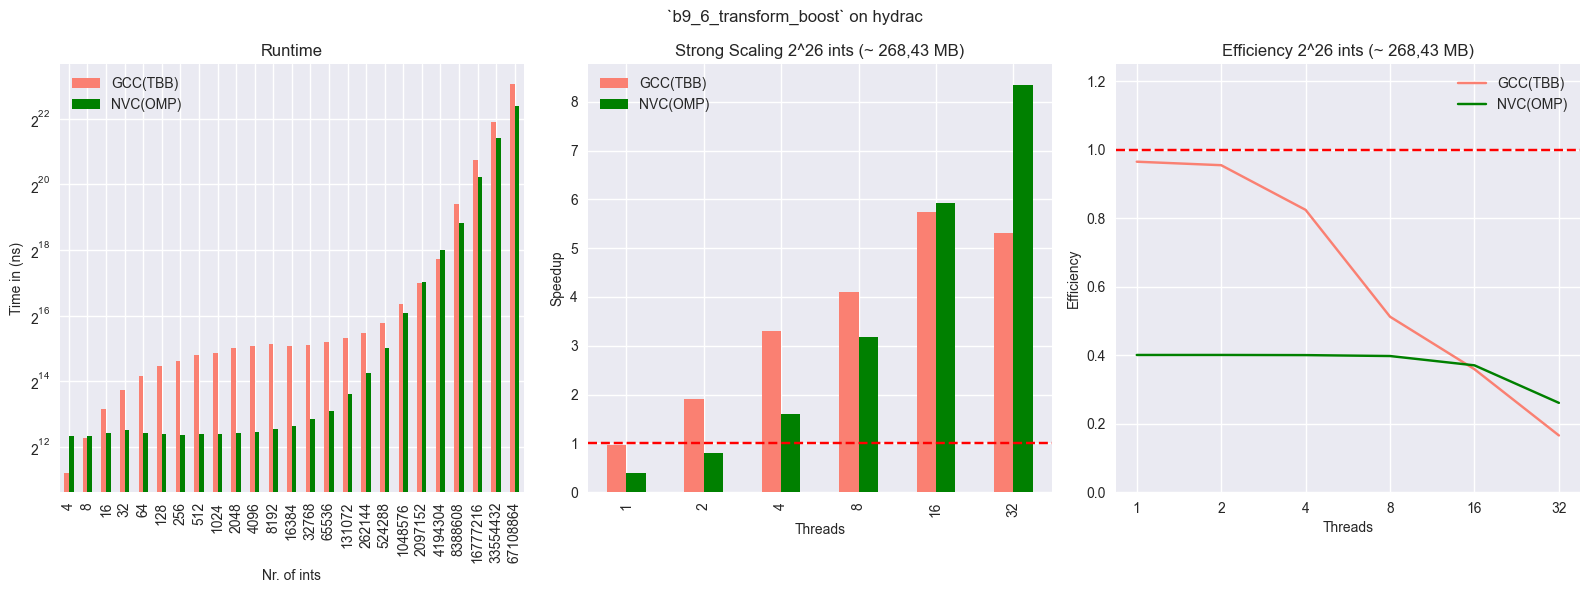

In [90]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_6_transform_boost_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_6_transform_boost_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_6_transform_boost_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_6_transform_boost` on {device_name}")

fig.tight_layout()

plot(f"`b9_6_transform_boost` {device_name}")

## Speedup comparison per strategy

In [91]:
impl_index_versions = [
    ('b9_1_transform_baseline'),
    ('b9_2_transform_old_iota'),
    ('b9_3_transform_views_iota'),
    ('b9_5_transform_custom_iterator'),
    ('b9_6_transform_boost'),
]

base_of = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

data_index_strategies_speedup : Dict[str,pd.DataFrame] = {}
data_index_strategies_efficiency : Dict[str,pd.DataFrame] = {}

for compiler_location, compiler_name in instances:
    data = [get_strong_scaling_algo(compiler_location,bench_name,bench_name,base_of) for bench_name in impl_index_versions ]

    # speedup data collector 
    data_index_strategies_speedup[compiler_name] = data[0]

    for i in range(1,len(data)):
        data_index_strategies_speedup[compiler_name] = pd.merge(data_index_strategies_speedup[compiler_name],data[i],on='threads')

    # efficiency 
    data_index_strategies_efficiency[compiler_name] = data_index_strategies_speedup[compiler_name].copy()

    for strat in impl_index_versions:
        data_index_strategies_efficiency[compiler_name][strat] = data_index_strategies_efficiency[compiler_name][strat] / data_index_strategies_efficiency[compiler_name]['threads']

data_index_strategies_efficiency[instances[0][1]]



,threads,b9_1_transform_baseline,b9_2_transform_old_iota,b9_3_transform_views_iota,b9_5_transform_custom_iterator,b9_6_transform_boost
0,1,0.992617,0.146711,1.006142,1.006244,0.998489
1,2,0.983476,0.084931,0.500405,0.989155,0.987949
2,4,0.825020,0.047028,0.257842,0.812177,0.852958
3,8,0.538031,0.024422,0.119541,0.537635,0.530188
4,16,0.337795,0.012406,0.059451,0.336747,0.371624
5,32,0.177195,0.006061,0.027514,0.169342,0.171553


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/1892062926.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_18190/1892062926.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


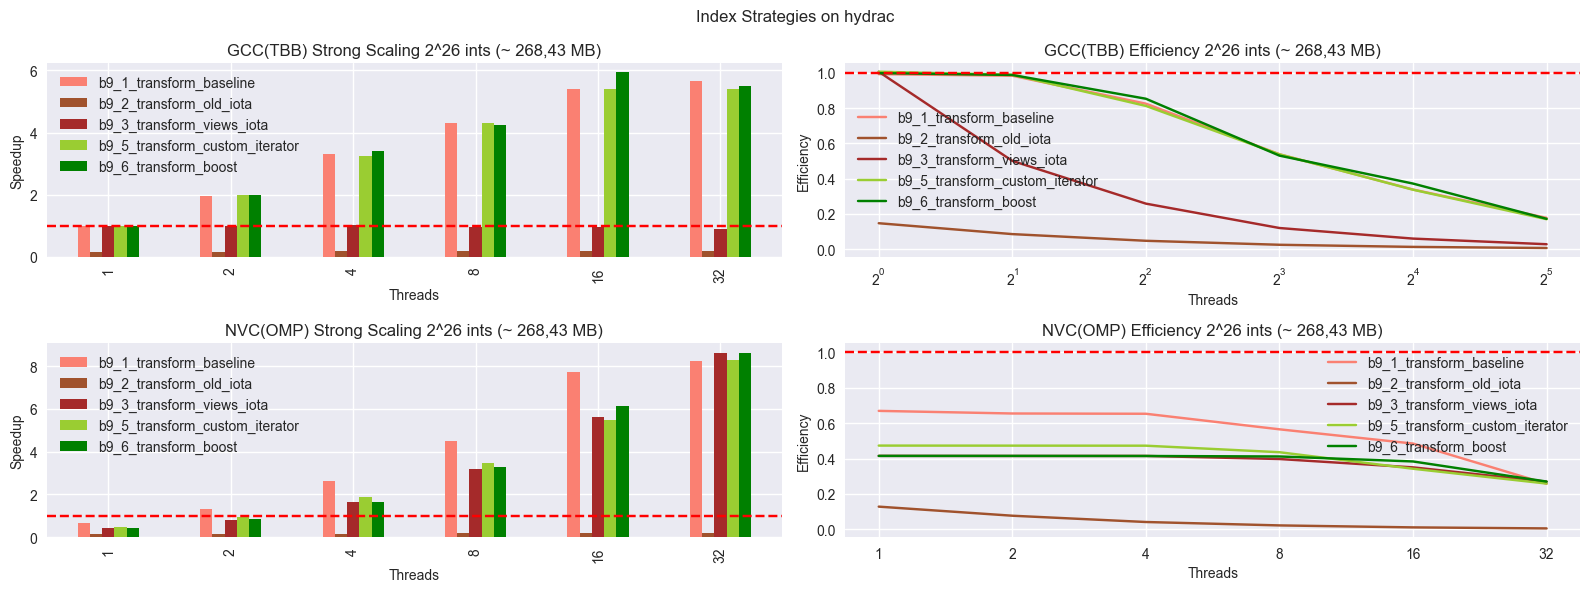

In [92]:
# graphs 

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6))


# plot strong scaling
ax_2 = data_index_strategies_speedup['GCC(TBB)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[0,0]
                                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('GCC(TBB) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = data_index_strategies_efficiency['GCC(TBB)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[0,1]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('GCC(TBB) Efficiency 2^26 ints (~ 268,43 MB)')







# plot strong scaling
ax_1 = data_index_strategies_speedup['NVC(OMP)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[1,0]
                                                                    )

# adding horizontal line where there is speedup
ax_1.axhline(y=1, color='r', linestyle='--')

#ax_1.set_ylim(0,3)
ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('NVC(OMP) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_4 = data_index_strategies_efficiency['NVC(OMP)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[1,1]
                                                            )

# adding horizontal line where there is speedup
ax_4.axhline(y=1, color='r', linestyle='--')

#ax_4.set_ylim(0,1.05)

ax_4.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('NVC(OMP) Efficiency 2^26 ints (~ 268,43 MB)')











fig.suptitle(f"Index Strategies on {device_name}")

fig.tight_layout()

plot(f"Index Strategies on {device_name}")


######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [93]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b9_1_transform_baseline',b9_1_transform_baseline_time_merged),
    ('b9_2_transform_old_iota',b9_2_transform_old_iota_time_merged),
    ('b9_3_transform_views_iota',b9_3_transform_views_iota_time_merged),
    ('b9_5_transform_custom_iterator',b9_5_transform_custom_iterator_time_merged),
    ('b9_6_transform_boost',b9_6_transform_boost_time_merged),
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df['GCC(TBB)'] = pp_df['GCC(TBB)'].astype('int')
pp_df['NVC(OMP)'] = pp_df['NVC(OMP)'].astype('int')

pp_df


,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b9_1_transform_baseline,8482870,5646820,0.799284,BAD
1,b9_2_transform_old_iota,245572000,261083000,0.969385,GOOD
2,b9_3_transform_views_iota,55119600,5669760,0.186538,BAD
3,b9_5_transform_custom_iterator,8730890,5555790,0.777758,BAD
4,b9_6_transform_boost,8831760,5525230,0.769692,BAD


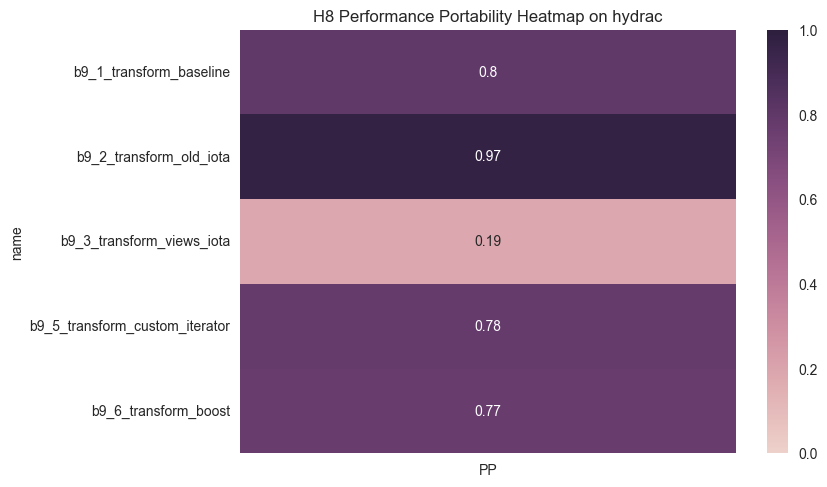

In [94]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H8 Performance Portability Heatmap on {device_name}')

plot(f'H8 Performance Portability Heatmap on {device_name}')

## Runtime difference between types

In [95]:
print('========= GCC(TBB) =========')

print('= ALL')
all_gcc_tbb = pp_df['GCC(TBB)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['GCC(TBB)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))



========= GCC(TBB) =========
= ALL
	Stddev: 102735748.2565194
	Performance Portability between types of indices: 0.12981184996672557

= ONLY EFFICIENT
	Stddev: 23219342.772302292
	Performance Portability between types of indices: 0.41805494774109864


In [96]:
print('========= NVC(OMP) =========')

print('= ALL')
all_gcc_tbb = pp_df['NVC(OMP)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['NVC(OMP)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))


========= NVC(OMP) =========
= ALL
	Stddev: 114255755.32262586
	Performance Portability between types of indices: 0.09745340598263162

= ONLY EFFICIENT
	Stddev: 69766.77098256256
	Performance Portability between types of indices: 0.9867539379219202


## Findings for H8

### XXX

### General


### GPU Findings


### Hypothesis Findings


